In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
#Importing Data

df = pd.read_csv('../data/processed/selected_features.csv',index_col=[0])
to_drop = ['Gini index','Country Name','Year']
X = df.drop(to_drop,axis=1).to_numpy() 

y = df['Gini index'].to_numpy()
groups = df['Country Name'].to_numpy()


#preprocessing pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA

preprocess_steps = [('scaler',StandardScaler()),
                    ('ct',ColumnTransformer([('pca',PCA(n_components=2),list(range(5,11)))],remainder='passthrough'))]


#Setting up cross-validation
from sklearn.model_selection import GroupKFold

gkf = GroupKFold(n_splits=5)

#Setting up model
from xgboost import XGBRegressor
from sklearn.pipeline import Pipeline

params = {'reg_lambda':0.4,
 'reg_alpha': 0.8,
 'n_estimators': 115,
 'max_depth': 2,
 'learning_rate': 0.4}

model = Pipeline(steps=preprocess_steps + [('xgb',XGBRegressor(**params))])


#Feature Names
columns = df.drop(to_drop,axis=1).columns.to_list()
feature_names = [col for col in columns if col.find('Poverty') < 0]

feature_names = ['poverty_pca0','poverty_pca1'] + feature_names

In [3]:
df.head()

,Year,"EA, at least completed lower secondary","COD, by injury","Population, total","Hospital beds (per 1,000 people)",Country Name,Gini index,Poverty headcount ratio at $3.65,Poverty headcount ratio at $6.85,Poverty gap at $2.15,Poverty gap at $3.65,Poverty headcount ratio at $2.15,Poverty gap at $6.85,GDP per capita
11420,2002,88.543221,8.507397,48202470.0,8.89,Ukraine,29.0,17.0,61.9,0.5,3.7,2.7,20.8,911.906871
11686,2003,88.543221,8.507397,47812949.0,8.81,Ukraine,28.7,10.4,54.1,0.2,2.1,1.1,16.0,1087.788007
12624,2007,95.692841,10.150055,5268400.0,5.06,Kyrgyz Republic,33.9,33.6,74.2,1.7,9.5,8.8,31.8,721.769526
12687,2007,61.490292,12.359977,3431614.0,2.30,Panama,52.7,14.9,30.5,2.2,5.7,6.7,13.6,6205.821576
12879,2008,80.522840,5.055017,4489544.0,4.85,Ireland,30.9,0.3,0.8,0.1,0.2,0.2,0.4,61353.106563


In [4]:
from sklearn.model_selection import cross_val_score


scores = cross_val_score(model,X,y,groups=groups,cv=gkf)
print(scores)
print(np.average(scores))

[0.645983   0.63001163 0.87701662 0.52879723 0.72160533]
0.68068276316463


In [5]:
folds = gkf.split(X,y,groups=groups)
feature_importances = {}
for f in feature_names:
    feature_importances[f] = []

for i in range(5):
    train_ind, test_ind = next(folds)
    X_train, y_train, X_test, y_test = X[train_ind], y[train_ind], X[test_ind], y[test_ind]

    model.fit(X_train,y_train)
    fold_fi = model.named_steps['xgb'].feature_importances_
    
    for j in range(len(feature_names)):
        feature_importances[feature_names[j]].append(fold_fi[j])

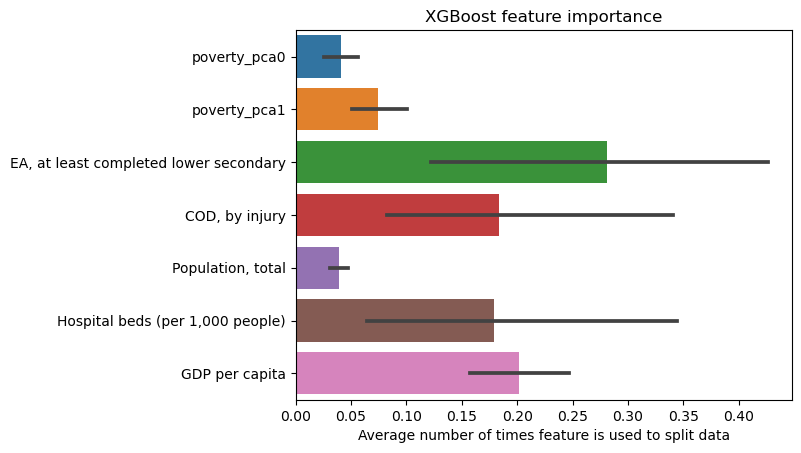

In [6]:
sns.barplot(pd.DataFrame(feature_importances),orient='h')
plt.title('XGBoost feature importance');
plt.xlabel('Average number of times feature is used to split data');

In [7]:
from sklearn.inspection import permutation_importance

folds = gkf.split(X,y,groups=groups)
permutation_importances = {}
for f in feature_names:
    permutation_importances[f] = []

for i in range(5):
    train_ind, test_ind = next(folds)
    X_train, y_train, X_test, y_test = X[train_ind], y[train_ind], X[test_ind], y[test_ind]

    preprocessor = Pipeline(steps=preprocess_steps)
    X_train = preprocessor.fit_transform(X_train)
    X_test = preprocessor.transform(X_test)
    xgb = XGBRegressor(**params)
    xgb.fit(X_train,y_train)
    perm = permutation_importance(xgb,X_test, y_test, random_state=1)
    fold_pi = perm.importances_mean # type: ignore
    for j in range(len(feature_names)):
        permutation_importances[feature_names[j]].append(fold_pi[j])

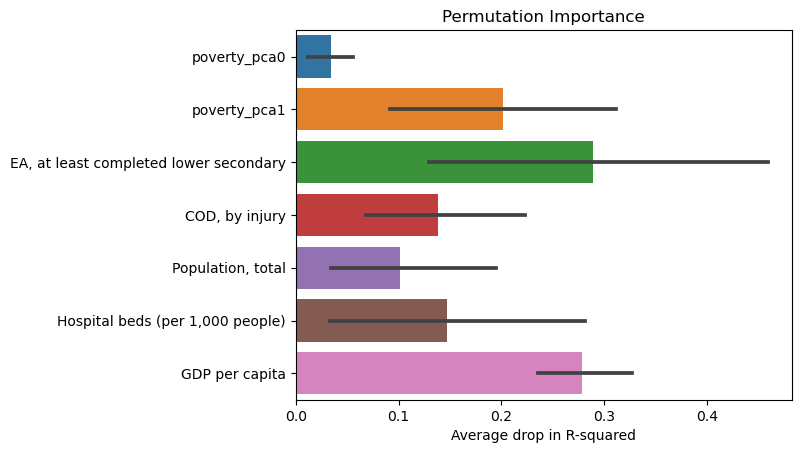

In [8]:
sns.barplot(pd.DataFrame(permutation_importances),orient='h')
plt.title('Permutation Importance')
plt.xlabel('Average drop in R-squared');

In [9]:
import warnings    #avoiding a few annoying sklearn warnings, feel free to skip this cell

def warn(*args,**kwargs):
    pass

warnings.warn = warn

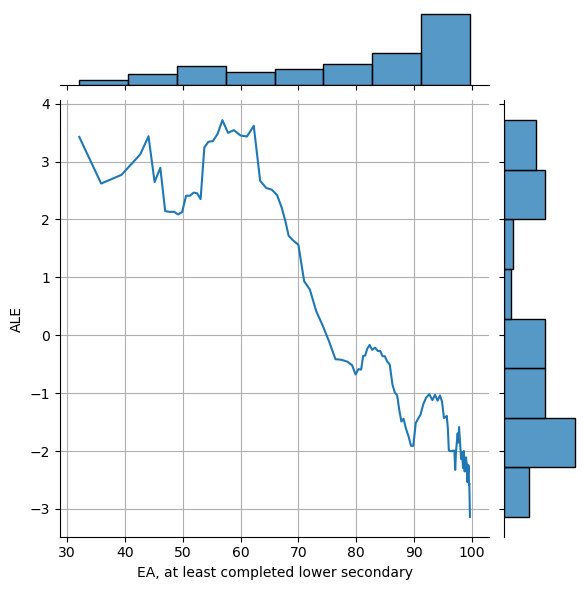

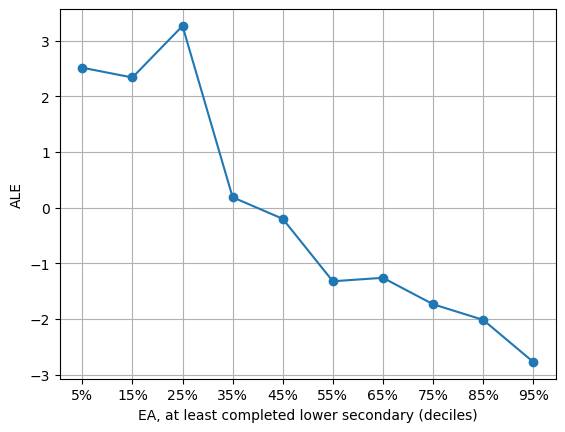

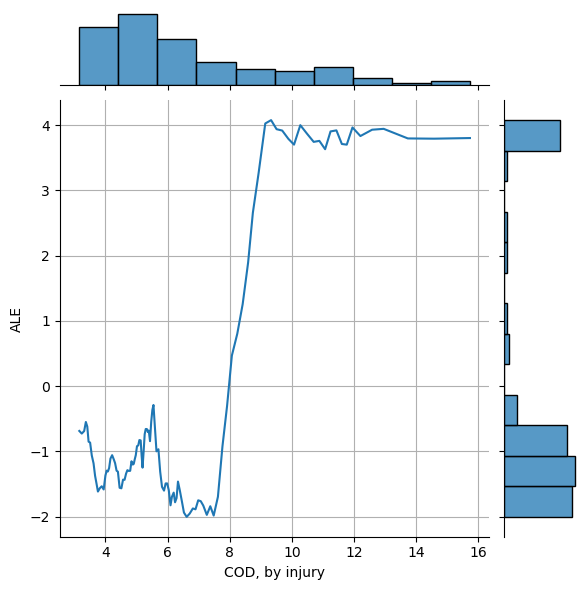

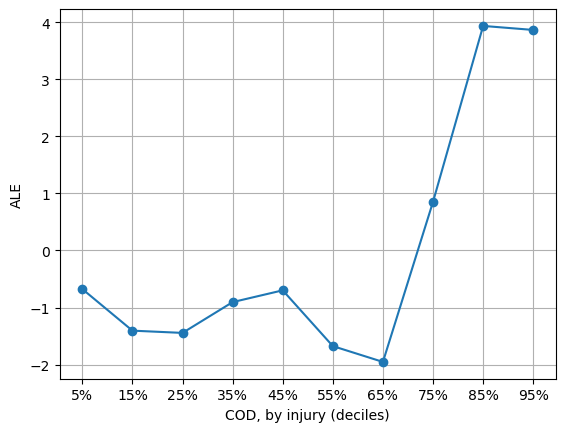

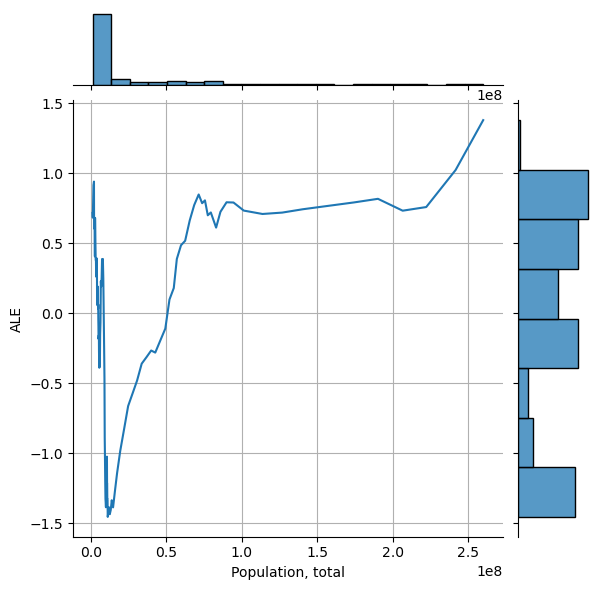

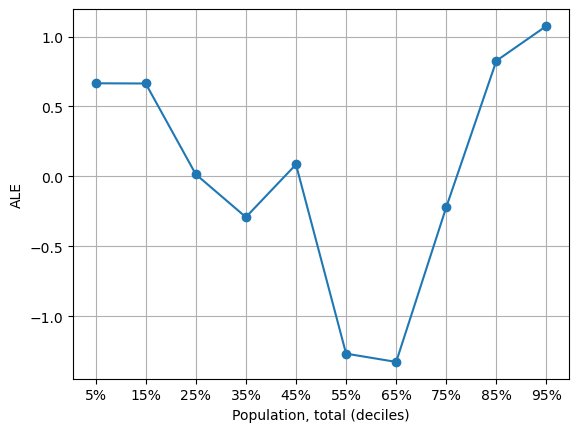

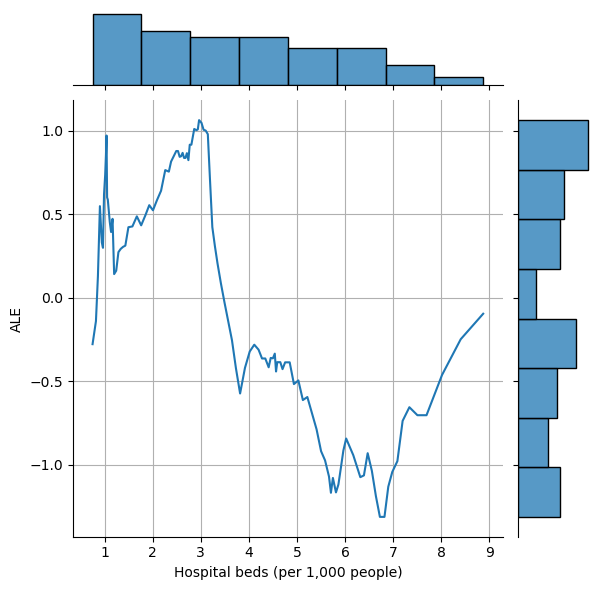

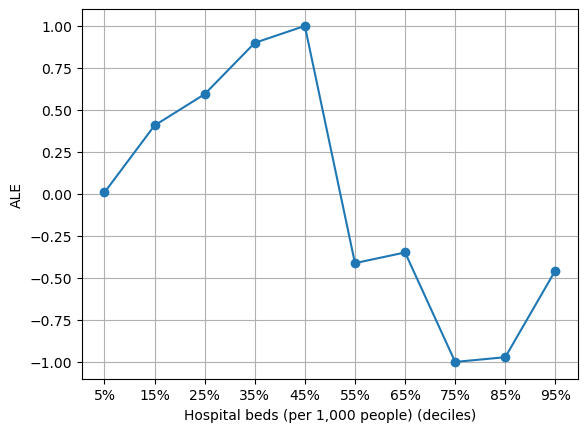

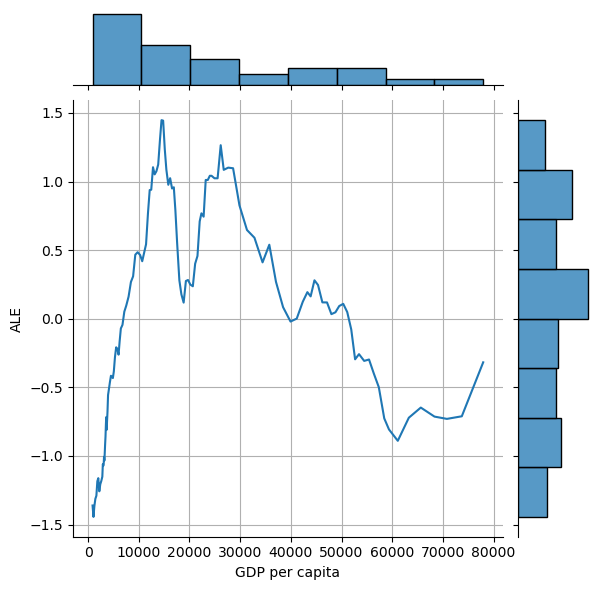

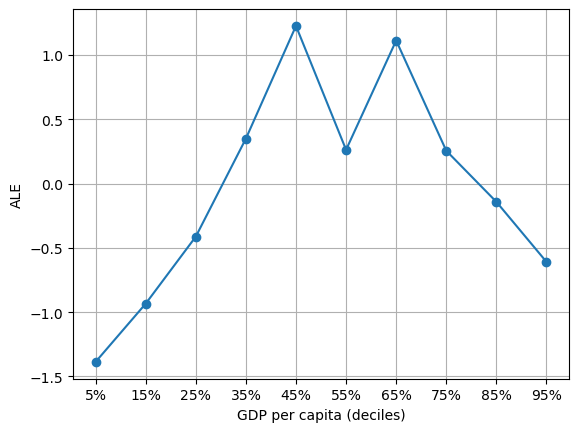

In [10]:
from PyALE import ale

for f in feature_names:
    if f.find('poverty') == -1:
        ale_eff = pd.DataFrame([[1]])
        folds = gkf.split(X,y,groups=groups)

        for i in range(5):
            train_ind, test_ind = next(folds)
            X_train, y_train, X_test, y_test = X[train_ind], y[train_ind], X[test_ind], y[test_ind]
            model.fit(X_train,y_train)

            co = df.drop(to_drop,axis=1).columns
            if len(ale_eff) == 1:
                ale_eff = ale(pd.DataFrame(X_test,columns=co),model,[f],grid_size=50,plot=False,feature_type='continuous')
            else: ale_eff = pd.concat([ale_eff,ale(pd.DataFrame(X_test,columns=co),model,[f],plot=False,feature_type='continuous')])
        
        ale_eff = ale_eff.sort_index()
        ale_eff[f] = ale_eff.index
        roll_ale = ale_eff.rolling(10).mean()
        roll_ale = roll_ale[~roll_ale.index.duplicated()]

        g = sns.JointGrid(data=roll_ale, x=f, y="eff")
        g.ax_joint.grid(True)
        g.ax_joint.set_ylabel('ALE')
        g.plot(sns.lineplot, sns.histplot)
        plt.show();

        xdeciles = np.percentile(ale_eff[f], np.arange(5, 100, 10))
        ydeciles = []
        
        for i in range(1,11):
            minp = i*10 - 10
            maxp = i*10
            min_x = np.percentile(ale_eff[f],minp) 
            max_x = np.percentile(ale_eff[f],maxp)
            ydeciles.append(ale_eff[(ale_eff[f] < max_x) & (ale_eff[f] > min_x)]['eff'].mean())
        
        plt.plot(np.arange(5, 100, 10),ydeciles,marker='o', linestyle='-')
        plt.xticks(np.arange(5, 100, 10), [f'{i}%' for i in np.arange(5, 100, 10)])
        plt.grid(True)
        plt.xlabel(f + ' (deciles)')
        plt.ylabel('ALE')
        plt.show()
        
        

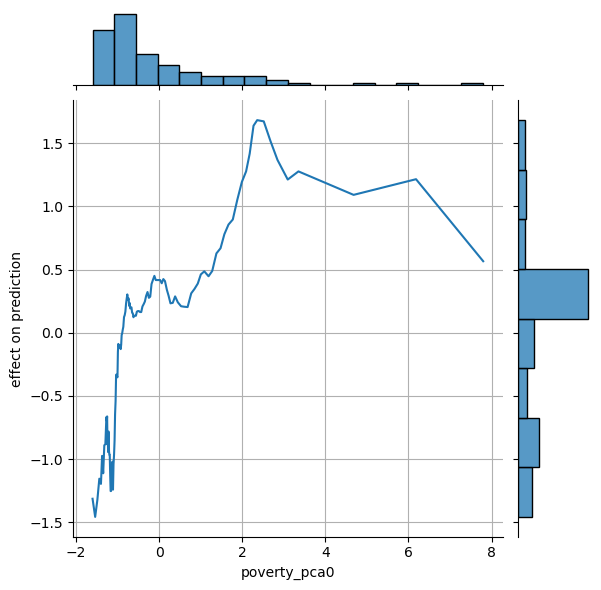

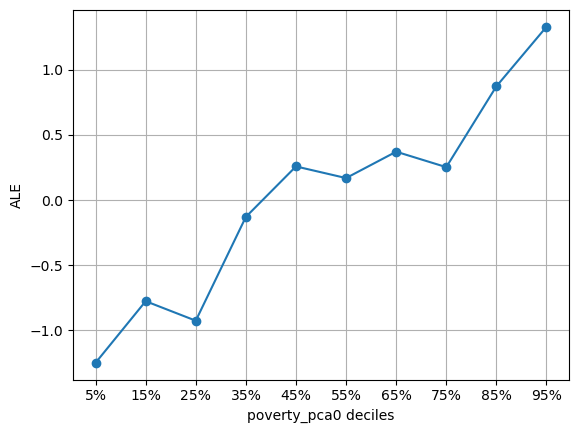

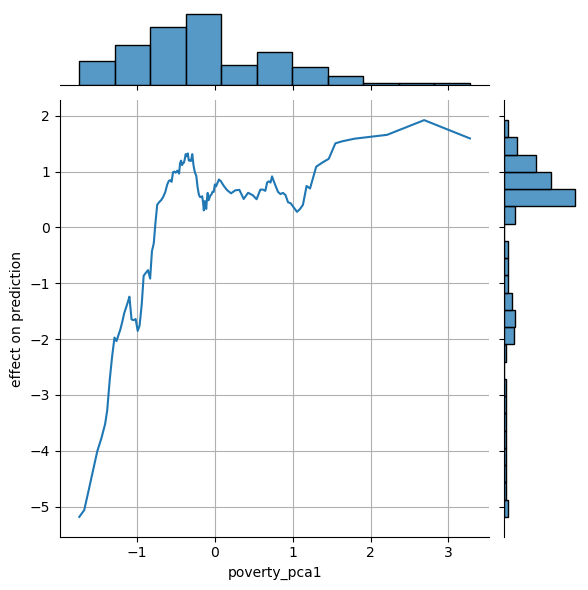

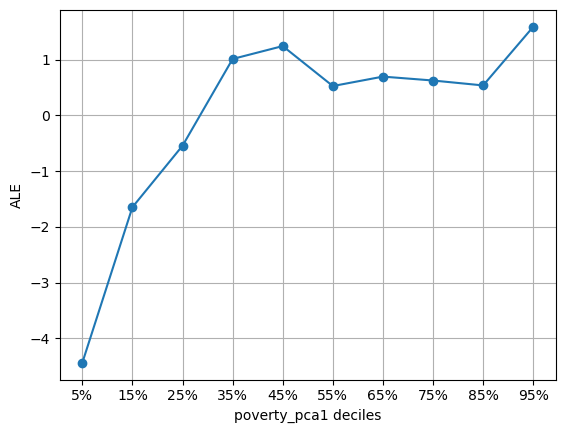

In [11]:
from PyALE import ale


for f in ['poverty_pca0','poverty_pca1']:
    ale_eff = pd.DataFrame([[1]])
    folds = gkf.split(X,y,groups=groups)

    for i in range(5):
        train_ind, test_ind = next(folds)
        X_train, y_train, X_test, y_test = X[train_ind], y[train_ind], X[test_ind], y[test_ind]

        preprocessor = Pipeline(steps=preprocess_steps)
        X_train = preprocessor.fit_transform(X_train)
        X_test = preprocessor.transform(X_test)
        xgb = XGBRegressor(**params)
        xgb.fit(X_train,y_train)

        if len(ale_eff) == 1:
            ale_eff = ale(pd.DataFrame(X_test,columns=feature_names),xgb,[f],grid_size=50,plot=False,feature_type='continuous')
        else: ale_eff = pd.concat([ale_eff,ale(pd.DataFrame(X_test,columns=feature_names),xgb,[f],plot=False,feature_type='continuous')])


    
    ale_eff = ale_eff.sort_index()
    ale_eff[f] = ale_eff.index
    roll_ale = ale_eff.rolling(10).mean()
    roll_ale = roll_ale[~roll_ale.index.duplicated()]

    g = sns.JointGrid(data=roll_ale, x=f, y="eff")
    g.ax_joint.grid(True)
    g.ax_joint.set_ylabel('effect on prediction')
    g.plot(sns.lineplot, sns.histplot)
    plt.show();

    xdeciles = np.percentile(ale_eff[f], np.arange(5, 100, 10))
    ydeciles = []

    for i in range(1,11):
        minp = i*10 - 10
        maxp = i*10
        min_x = np.percentile(ale_eff[f],minp) 
        max_x = np.percentile(ale_eff[f],maxp)
        ydeciles.append(ale_eff[(ale_eff[f] < max_x) & (ale_eff[f] > min_x)]['eff'].mean())

    plt.plot(np.arange(5, 100, 10),ydeciles,marker='o', linestyle='-')
    plt.xticks(np.arange(5, 100, 10), [f'{i}%' for i in np.arange(5, 100, 10)])
    plt.grid(True)
    plt.xlabel(f + ' deciles')
    plt.ylabel('ALE')
    plt.show()

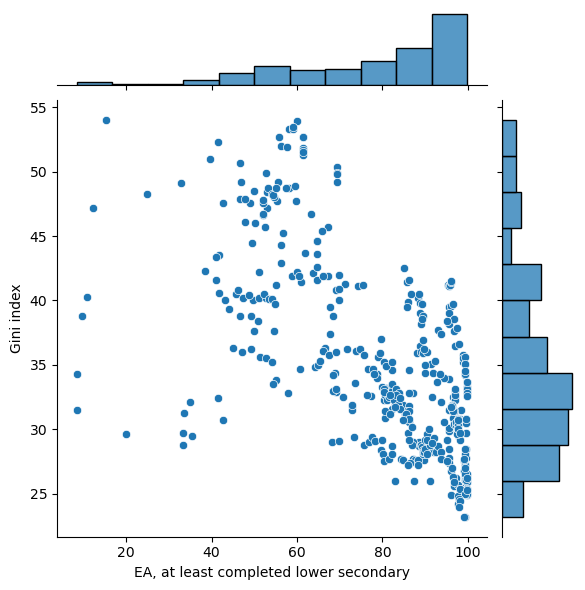

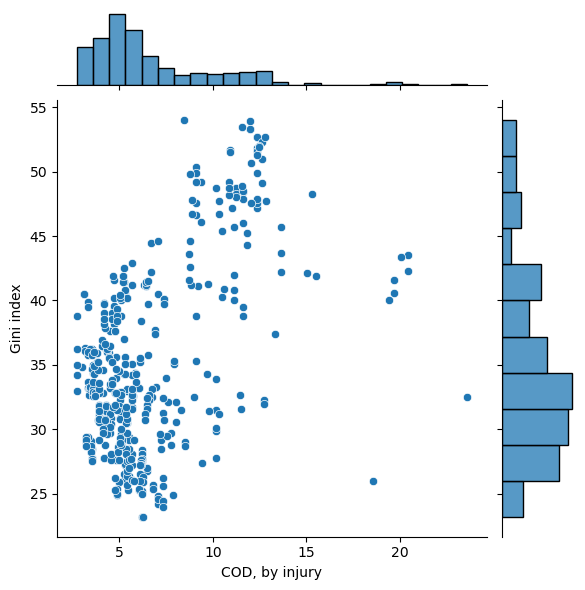

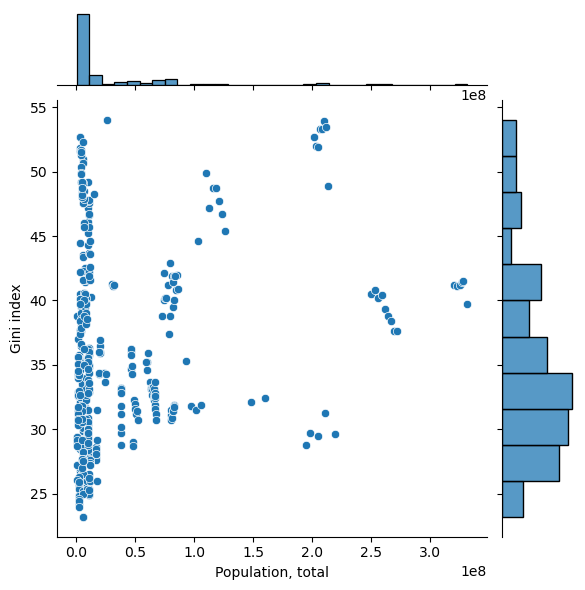

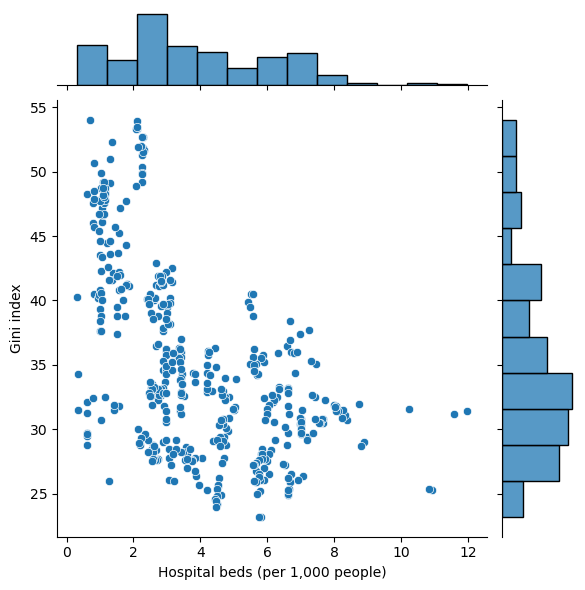

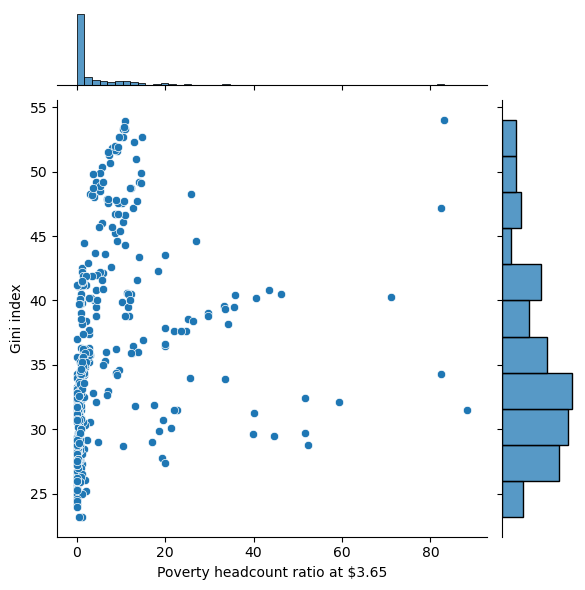

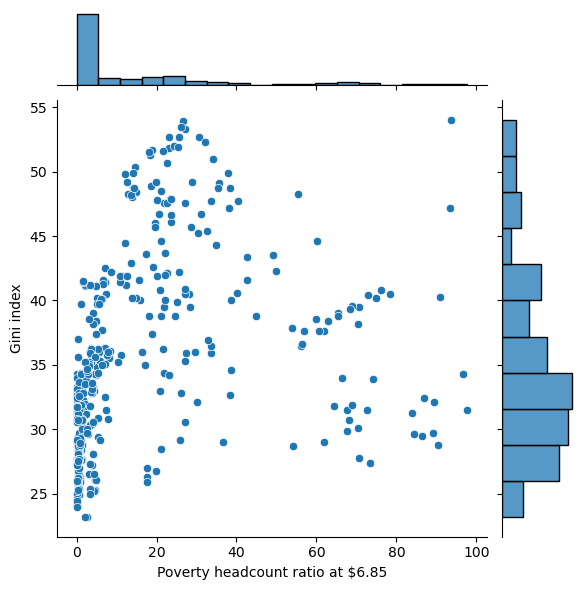

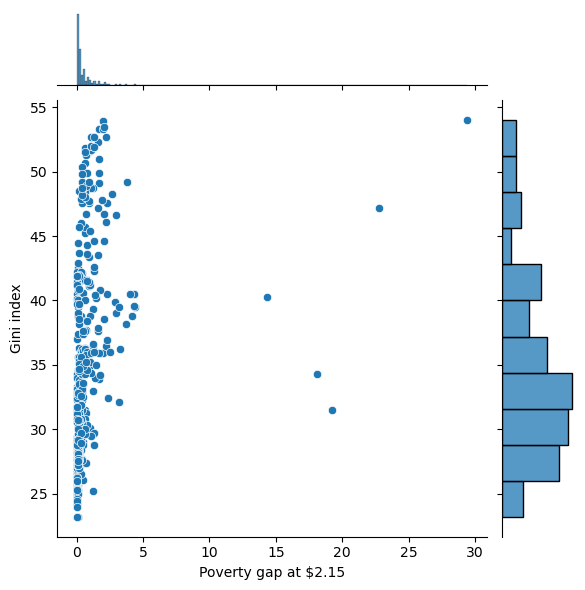

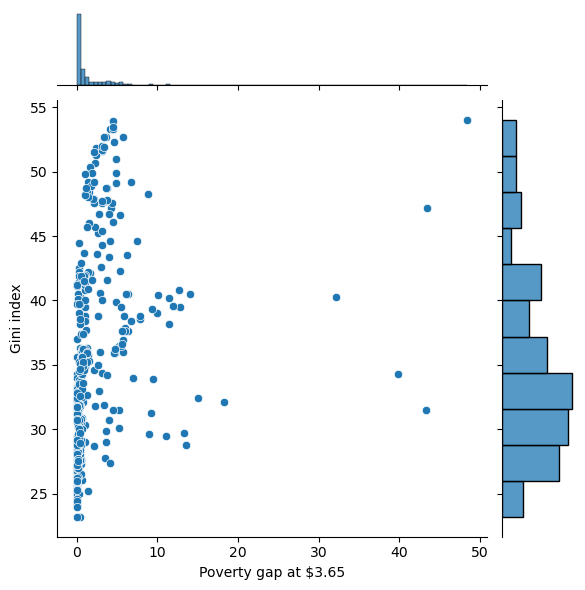

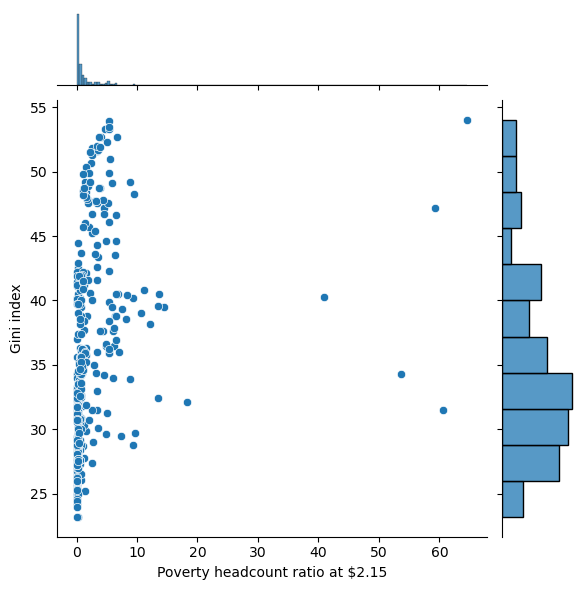

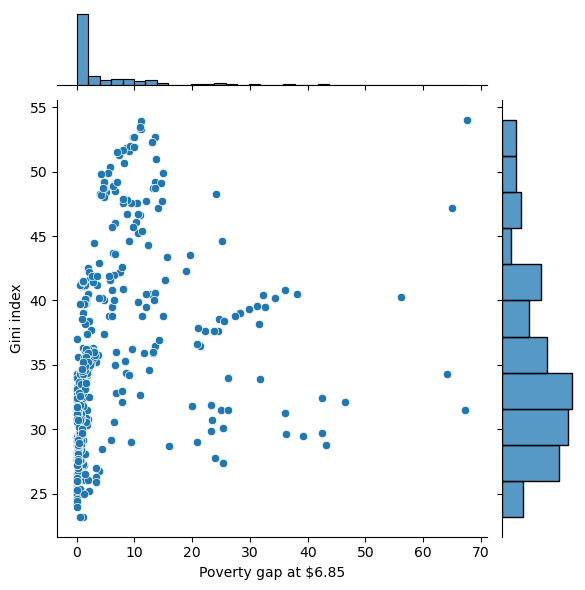

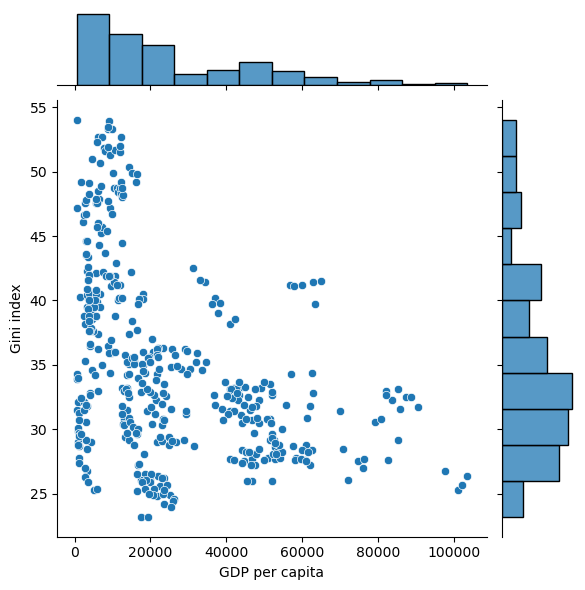

In [16]:
for col in df.columns:
    if not col in ['Year','Gini index','Country Name']:
        sns.jointplot(data=df, x=col,y='Gini index')
        plt.show()

In [18]:
from sklearn.calibration import cross_val_predict
from sklearn.metrics import r2_score

df['predicted Gini index'] = cross_val_predict(model,X,y,groups=groups,cv=gkf)
df['Residuals'] = df['predicted Gini index'] - df['Gini index']

r2_score(df['Gini index'],df['predicted Gini index'])

0.7232279857778094

In [19]:
by_country_count = df[['Country Name','Year']].groupby(by='Country Name').agg('count')

by_country_count

,Year
Country Name,
Albania,3
Australia,3
Austria,7
Bangladesh,2
Belarus,2
...,...
United Arab Emirates,2
United Kingdom,11
United States,6


In [20]:
by_country = df[['Country Name','Residuals','Gini index','predicted Gini index']].groupby(by='Country Name').agg('mean')

by_country['Sample Size (Years)'] = df[['Country Name','Year']].groupby(by='Country Name').agg('count')
by_country.head()
by_country['Country Name'] = by_country.index

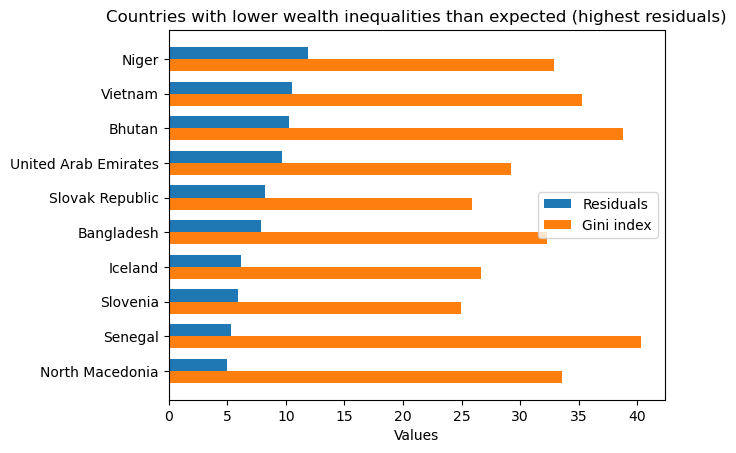

In [21]:
highresid = by_country.nlargest(10,'Residuals').sort_values(by='Residuals')

# Set up the positions for the bars
y = np.arange(len(highresid))
width = 0.35  # Width of the bars

# Create the barplot
fig, ax = plt.subplots()
bar1 = ax.barh(y + width/2, highresid['Residuals'], width, label='Residuals')
bar2 = ax.barh(y - width/2, highresid['Gini index'], width, label='Gini index')



# Add labels, title, and legend
ax.set_yticks(y)
ax.set_yticklabels(highresid['Country Name'])
ax.set_xlabel('Values')
ax.set_title('Countries with lower wealth inequalities than expected (highest residuals)')
ax.legend(loc='right')

# Show the plot
plt.show()

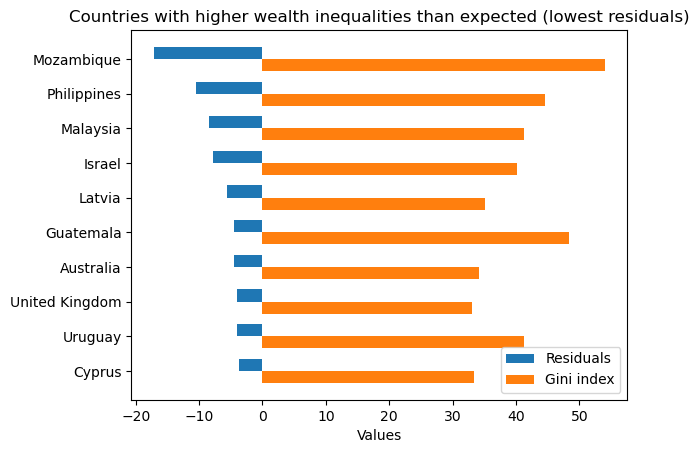

In [22]:

lowresid = by_country.nsmallest(10,'Residuals').sort_values(by='Residuals',ascending=False)

# Set up the positions for the bars
y = np.arange(len(lowresid))
width = 0.35  # Width of the bars

# Create the barplot
fig, ax = plt.subplots()
bar1 = ax.barh(y + width/2, lowresid['Residuals'], width, label='Residuals')
bar2 = ax.barh(y - width/2, lowresid['Gini index'], width, label='Gini index')

# Add labels, title, and legend
ax.set_yticks(y)
ax.set_yticklabels(lowresid['Country Name'])
ax.set_xlabel('Values')
ax.set_title('Countries with higher wealth inequalities than expected (lowest residuals)')
ax.legend(loc='lower right')

# Show the plot
plt.show()

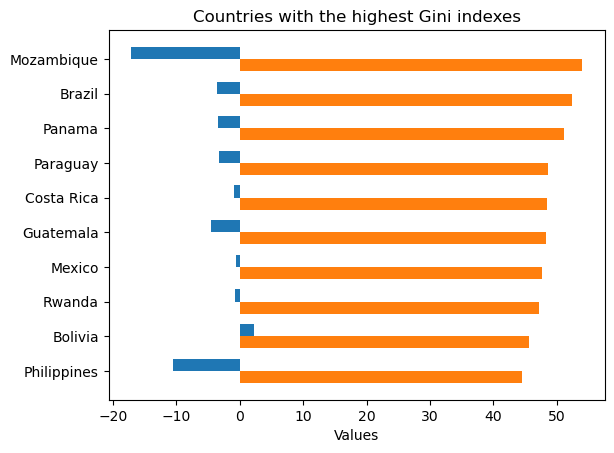

In [23]:
highgini = by_country.nlargest(10,'Gini index').sort_values(by='Gini index')

# Set up the positions for the bars
y = np.arange(len(highgini))
width = 0.35  # Width of the bars

# Create the barplot
fig, ax = plt.subplots()
bar1 = ax.barh(y + width/2, highgini['Residuals'], width, label='Residuals')
bar2 = ax.barh(y - width/2, highgini['Gini index'], width, label='Gini index')



# Add labels, title, and legend
ax.set_yticks(y)
ax.set_yticklabels(highgini['Country Name'])
ax.set_xlabel('Values')
ax.set_title('Countries with the highest Gini indexes')
#ax.legend(loc='best')

# Show the plot
plt.show()

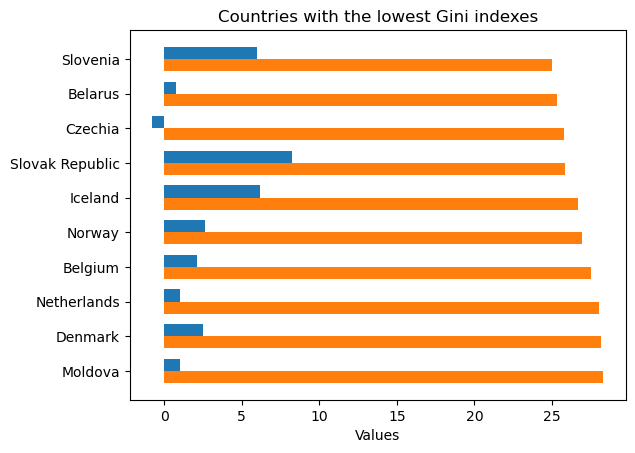

In [24]:
lowgini = by_country.nsmallest(10,'Gini index').sort_values(by='Gini index',ascending=False)

# Set up the positions for the bars
y = np.arange(len(lowgini))
width = 0.35  # Width of the bars

# Create the barplot
fig, ax = plt.subplots()
bar1 = ax.barh(y + width/2, lowgini['Residuals'], width, label='Residuals')
bar2 = ax.barh(y - width/2, lowgini['Gini index'], width, label='Gini index')



# Add labels, title, and legend
ax.set_yticks(y)
ax.set_yticklabels(lowgini['Country Name'])
ax.set_xlabel('Values')
ax.set_title('Countries with the lowest Gini indexes')
#ax.legend(loc='right')

# Show the plot
plt.show()